In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import pandas as pd

from requests import get
from urllib.parse import urlparse
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler


import matplotlib.cm as cm
import matplotlib.pyplot as plt

import random
random.seed(31)
np.random.seed(31)

from IPython.display import Image


In [2]:
ddir  = os.path.join('data') 
odir  = os.path.join('output') 

In [3]:
#load the merged data and the shape of London MSOAS
msoas = gpd.read_file(ddir+"\\London_MSOAs.gpkg",low_memory=False)
msoa_df = pd.read_csv(ddir+'\\msoa_travel_profile_merged.csv',low_memory=False)

C:\Users\Hongsheng\anaconda3\envs\urbsim\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [4]:
#join the data to the shape of MSOAs
msoa_gdf = msoas.join(
                msoa_df, 
                rsuffix='_r').fillna(0)

In [5]:
msoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   OBJECTID                     983 non-null    int64   
 1   MSOA11CD                     983 non-null    object  
 2   MSOA11NM                     983 non-null    object  
 3   BNG_E                        983 non-null    int64   
 4   BNG_N                        983 non-null    int64   
 5   Borough                      983 non-null    object  
 6   msoa11hclnm                  983 non-null    object  
 7   geometry                     983 non-null    geometry
 8   OBJECTID_r                   983 non-null    int64   
 9   MSOA11CD_r                   983 non-null    object  
 10  BNG_E_r                      983 non-null    int64   
 11  BNG_N_r                      983 non-null    int64   
 12  Borough_r                    983 non-null    object  
 1

In [6]:
#drop the duplicates
list_drop_columns = ['OBJECTID_r','MSOA11CD_r','BNG_E_r','BNG_N_r','Borough_r','msoa11hclnm_r','geometry_r']
msoa_gdf.drop(list_drop_columns, axis=1, inplace= True)

In [7]:
msoa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   OBJECTID                     983 non-null    int64   
 1   MSOA11CD                     983 non-null    object  
 2   MSOA11NM                     983 non-null    object  
 3   BNG_E                        983 non-null    int64   
 4   BNG_N                        983 non-null    int64   
 5   Borough                      983 non-null    object  
 6   msoa11hclnm                  983 non-null    object  
 7   geometry                     983 non-null    geometry
 8   pub_tra_stops                983 non-null    float64 
 9   bus_stops                    983 non-null    float64 
 10  rail_stops                   983 non-null    float64 
 11  Middle Super Output Area     983 non-null    object  
 12  BAME_per_2011                983 non-null    float64 
 1

In [8]:
# subset the original variables for k-means clustering
list_4_traffic_profiles = ['MSOA11CD',
                           'bus_stops_den', 'rail_stops_den',  
                           'one_car_or_more_per_2011', 
                           'car_ave_t', 'bus_ave_t', 'rail_ave_t','total_ave_t', 
                           'car_per', 'bus_per', 'rail_per']

df_trans = msoa_gdf[list_4_traffic_profiles]

# rename the variables
df_1 = df_trans.rename(columns={'bus_stops_den': 'Bus stops density (/hectare)', 
                          'rail_stops_den': 'Rail stops density (/hectare)', 
                          'one_car_or_more_per_2011': 'Percentage of households with cars', 
                          'car_ave_t': 'Average commuting time for car (min)', 
                          'bus_ave_t': 'Average commuting time for bus (min)', 
                          'rail_ave_t': 'Average commuting time for rail (min)', 
                          'total_ave_t': 'Total average commuting time (min)', 
                          'car_per': 'Percentage of commuting by car', 
                          'bus_per': 'Percentage of commuting by bus', 
                          'rail_per': 'Percentage of commuting by rail', 
                       })

In [9]:
sns.set(style="darkgrid",font_scale = 1.1)

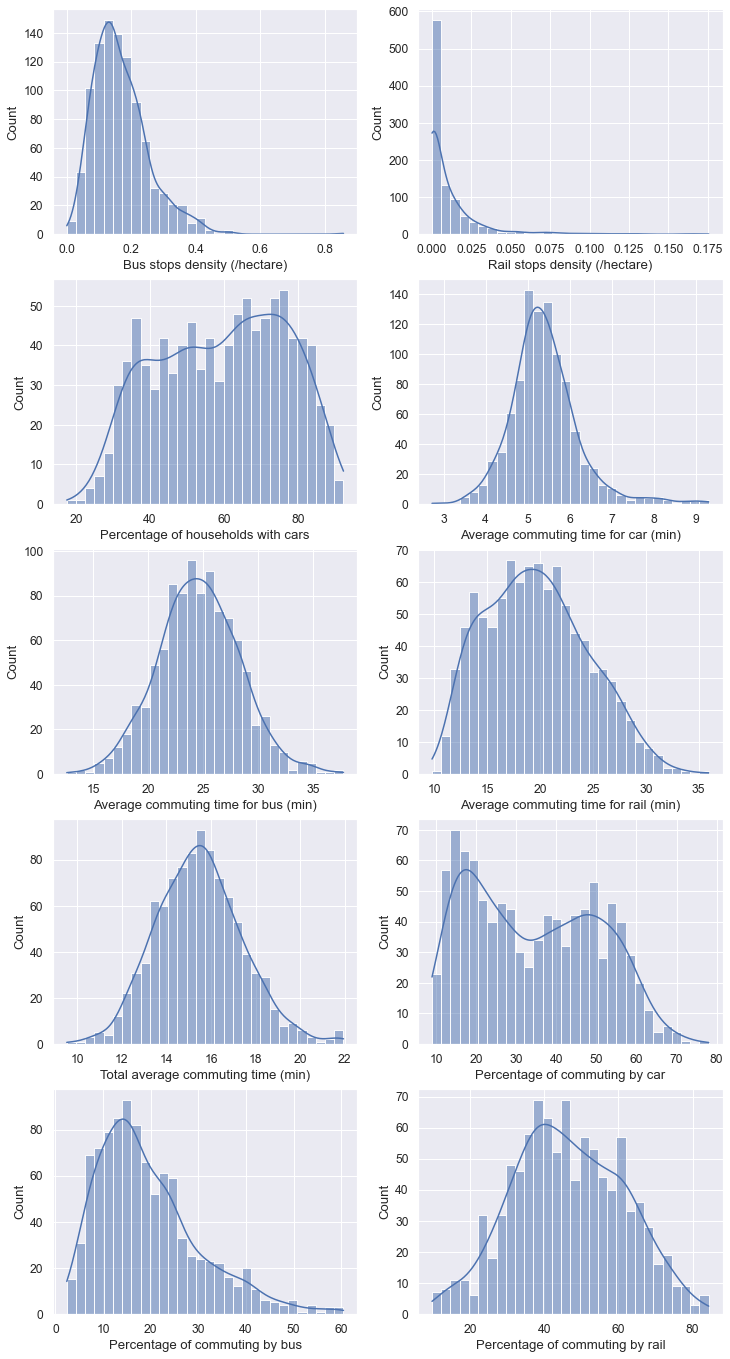

In [10]:
# plot the distribution of original variables for k-means clustering
fig, axs = plt.subplots(5, 2, figsize=(12, 24))
sns.histplot(data=df_1, x="Bus stops density (/hectare)", kde=True, ax=axs[0, 0], bins=30)
sns.histplot(data=df_1, x="Rail stops density (/hectare)", kde=True, ax=axs[0, 1], bins=30)
sns.histplot(data=df_1, x="Percentage of households with cars", kde=True, ax=axs[1, 0], bins=30)
sns.histplot(data=df_1, x="Average commuting time for car (min)", kde=True, ax=axs[1, 1], bins=30)
sns.histplot(data=df_1, x="Average commuting time for bus (min)", kde=True, ax=axs[2, 0], bins=30)
sns.histplot(data=df_1, x="Average commuting time for rail (min)", kde=True, ax=axs[2, 1], bins=30)
sns.histplot(data=df_1, x="Total average commuting time (min)", kde=True, ax=axs[3, 0], bins=30)
sns.histplot(data=df_1, x="Percentage of commuting by car", kde=True, ax=axs[3, 1], bins=30)
sns.histplot(data=df_1, x="Percentage of commuting by bus", kde=True, ax=axs[4, 0], bins=30)
sns.histplot(data=df_1, x="Percentage of commuting by rail", kde=True, ax=axs[4, 1], bins=30)
plt.savefig(odir+'\\trans_before.png', bbox_inches = 'tight') 
plt.show()

In [11]:
#log transformation for skewed variables
list_for_log = ['bus_stops_den', 'rail_stops_den']
attributes_log=[]
df_trans['log_bus_stops_den'] = np.log10(df_trans['bus_stops_den']+0.05)
attributes_log.append('log_bus_stops_den')
df_trans['log_rail_stops_den'] = np.log10(df_trans['rail_stops_den']+0.05)
attributes_log.append('log_rail_stops_den')

C:\Users\Hongsheng\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Hongsheng\anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


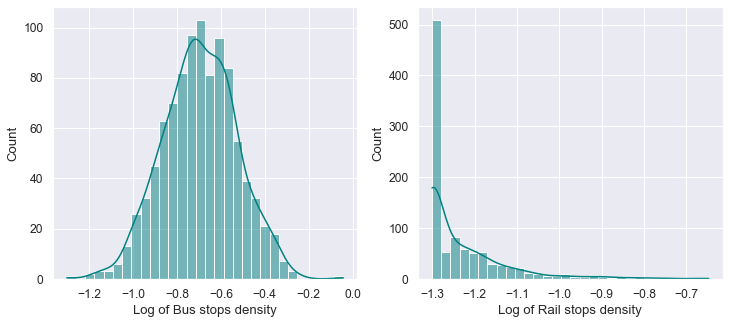

In [12]:
# subset the transformed variables for k-means clustering
df_trans_after=df_trans[['MSOA11CD','log_bus_stops_den', 'log_rail_stops_den',  
                           'one_car_or_more_per_2011', 
                           'car_ave_t', 'bus_ave_t', 'rail_ave_t','total_ave_t', 
                           'car_per', 'bus_per', 'rail_per']].set_index('MSOA11CD')

# rename the variables 
df_2 = df_trans_after.rename(columns={'log_bus_stops_den': 'Log of Bus stops density', 
                          'log_rail_stops_den': 'Log of Rail stops density', 
                          'one_car_or_more_per_2011': 'Percentage of households with cars', 
                          'car_ave_t': 'Average commuting time for car (min)', 
                          'bus_ave_t': 'Average commuting time for bus (min)', 
                          'rail_ave_t': 'Average commuting time for rail (min)', 
                          'total_ave_t': 'Total average commuting time (min)', 
                          'car_per': 'Percentage of commuting by car', 
                          'bus_per': 'Percentage of commuting by bus', 
                          'rail_per': 'Percentage of commuting by rail', 
                       })

# plot the distribution of two transformed variables 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df_2, x="Log of Bus stops density", color="teal", kde=True, ax=axs[0], bins=30)
sns.histplot(data=df_2, x="Log of Rail stops density", color="teal", kde=True, ax=axs[1], bins=30)
plt.savefig(odir+'//trans_after.png', bbox_inches = 'tight') 
plt.show()

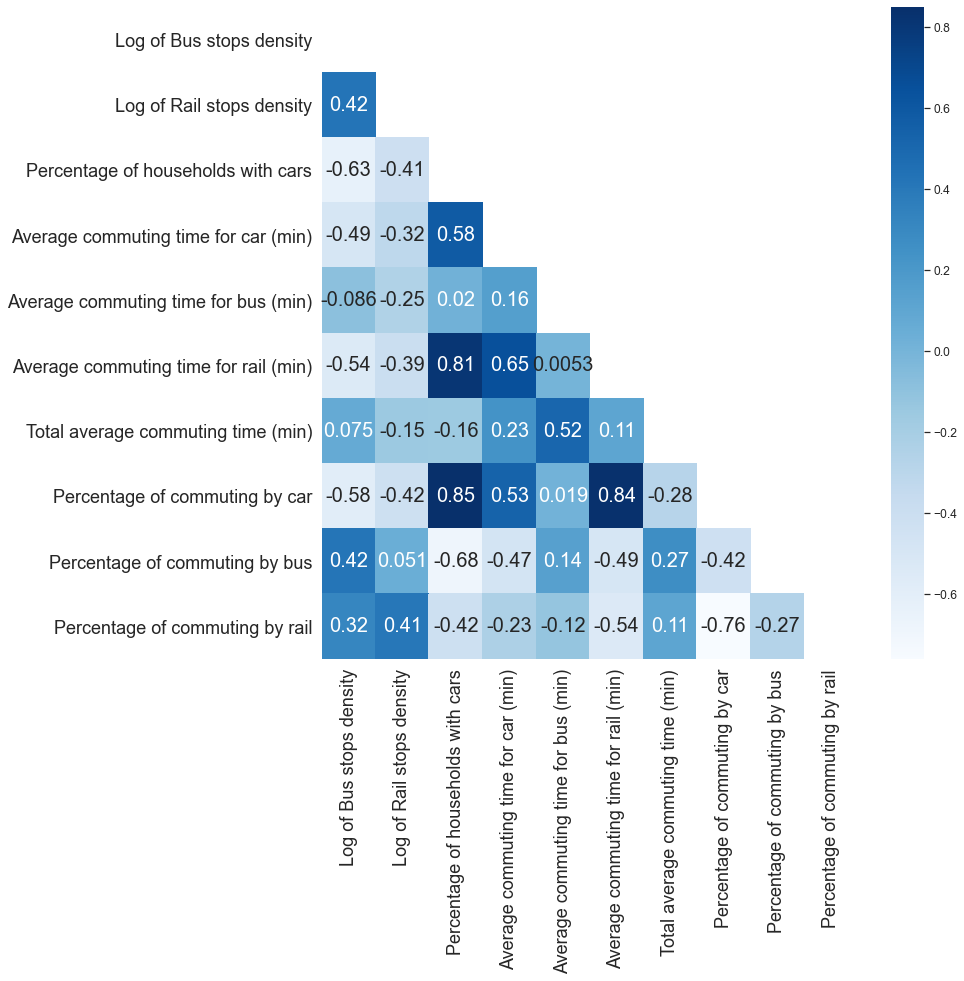

In [13]:
# correlation matrix of the transformed variables 
sns.set_style('white')
cluster_attr = ['log_bus_stops_den', 'log_rail_stops_den',  
                           'one_car_or_more_per_2011', 
                           'car_ave_t', 'bus_ave_t', 'rail_ave_t','total_ave_t', 
                           'car_per', 'bus_per', 'rail_per'] 
df_c = df_2
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 12))
mask = np.zeros_like(df_c.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_c.corr(), cmap="Blues", annot=True,annot_kws={'fontsize':20}, mask=mask)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig(odir+'//Correlation_Matrix_1.png', bbox_inches = 'tight')


In [14]:
df_c.head()

,Log of Bus stops density,Log of Rail stops density,Percentage of households with cars,Average commuting time for car (min),Average commuting time for bus (min),Average commuting time for rail (min),Total average commuting time (min),Percentage of commuting by car,Percentage of commuting by bus,Percentage of commuting by rail
MSOA11CD,,,,,,,,,,
E02000001,-0.270396,-0.666288,30.6,3.569505,16.899373,13.371135,13.002154,10.522332,18.773656,70.704012
E02000002,-0.846164,-1.301030,62.4,6.126413,24.030634,24.593929,14.827244,52.290076,19.529262,28.180662
E02000003,-0.872786,-1.262263,68.8,6.021906,26.214052,22.773933,15.599571,45.671349,13.851682,40.476968
E02000004,-0.990779,-1.301030,76.0,6.974718,20.872682,24.246238,14.228945,55.243243,14.108108,30.648649
E02000005,-0.872328,-1.301030,66.1,5.426414,23.209606,22.505966,13.975374,50.780261,20.244623,28.975116


In [15]:
# standardize the variables by the min-max method
var=cluster_attr
mms = MinMaxScaler(feature_range = (-1, 1))
cldf = df_c
for c in cldf.columns:
    cldf[c] = mms.fit_transform(cldf[c].values.reshape(-1,1))
rs   = pd.merge(msoas, cldf, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')
cldf.head(2)

,Log of Bus stops density,Log of Rail stops density,Percentage of households with cars,Average commuting time for car (min),Average commuting time for bus (min),Average commuting time for rail (min),Total average commuting time (min),Percentage of commuting by car,Percentage of commuting by bus,Percentage of commuting by rail
MSOA11CD,,,,,,,,,,
E02000001,0.637337,0.939899,-0.649733,-0.743301,-0.657909,-0.726434,-0.440797,-0.955496,-0.435429,0.634345
E02000002,-0.277368,-1.000000,0.200535,0.032677,-0.090852,0.131807,-0.146869,0.254409,-0.409410,-0.506473


In [16]:
sns.set_style('darkgrid')

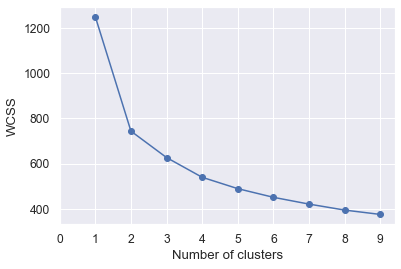

In [17]:
# the elbow plot for k-means clustering
wcss=[]
for i in range(1,10): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=31).fit(cldf)
    wcss.append(kmeans.inertia_)
#plt.figure(figsize=(9, 6))
plt.plot(range(1,10),wcss,marker='o')
#plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0, 10, step=1))
plt.ylabel('WCSS')
plt.savefig(odir+'//elbow_method.png', bbox_inches = 'tight')
plt.show()

........
Largest silhouette score was 0.3433 for k=2


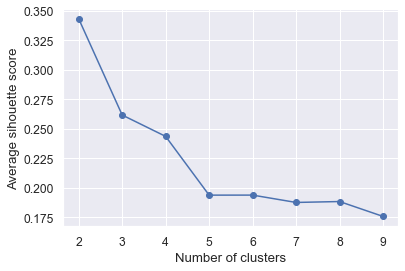

In [18]:
# the silhouette plot for k-means clustering
# adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score
x = []
y = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=31).fit(cldf)
    silhouette_avg = silhouette_score(cldf, kmeans.labels_)
    y.append(k)
    x.append(silhouette_avg)
    print('.', end='')
print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")
#plt.figure(figsize=(9, 6))
plt.plot(y, x, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average sihouette score')
#plt.gcf().suptitle("Average Silhouette Scores");
plt.savefig(odir+'//silhouette score.png', bbox_inches = 'tight')

In [19]:
cldf.head()

,Log of Bus stops density,Log of Rail stops density,Percentage of households with cars,Average commuting time for car (min),Average commuting time for bus (min),Average commuting time for rail (min),Total average commuting time (min),Percentage of commuting by car,Percentage of commuting by bus,Percentage of commuting by rail
MSOA11CD,,,,,,,,,,
E02000001,0.637337,0.939899,-0.649733,-0.743301,-0.657909,-0.726434,-0.440797,-0.955496,-0.435429,0.634345
E02000002,-0.277368,-1.000000,0.200535,0.032677,-0.090852,0.131807,-0.146869,0.254409,-0.409410,-0.506473
E02000003,-0.319662,-0.881519,0.371658,0.000961,0.082768,-0.007373,-0.022487,0.062682,-0.604914,-0.176588
E02000004,-0.507113,-1.000000,0.564171,0.290123,-0.341963,0.105218,-0.243224,0.339955,-0.596084,-0.440262
E02000005,-0.318934,-1.000000,0.299465,-0.179761,-0.156137,-0.027866,-0.284062,0.210674,-0.384777,-0.485160


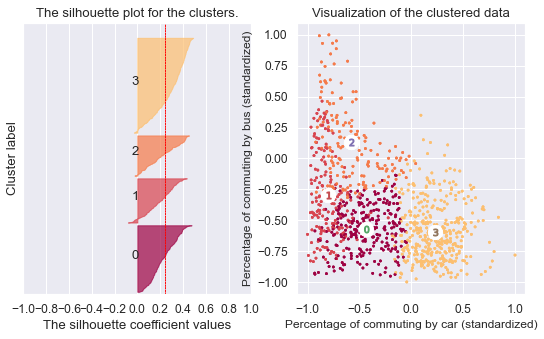

In [20]:
# conduct k-means clustering and show the silhouette results
c_nm   = 'KMeans'
k_pref = 4
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=31).fit(cldf)
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)
rs[c_nm] = s
    

silhouette_avg = silhouette_score(cldf, kmeans.labels_)

sample_silhouette_values = silhouette_samples(cldf, kmeans.labels_)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)
ax1.set_xlim([-1.0, 1.0]) 
ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
for i in range(k_pref):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([]) 
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) 

    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[7]], cldf[cldf.columns[8]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)
    
    centers = kmeans.cluster_centers_
    
    ax2.scatter(centers[:, 7], centers[:, 8],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[7], c[8], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Percentage of commuting by car (standardized)",size=12)
    ax2.set_ylabel("Percentage of commuting by bus (standardized)", size=12)

#plt.suptitle(("Silhouette results for KMeans clustering "
#                "with %d clusters" % k_pref),
#                fontsize=14, fontweight='bold')
plt.savefig(odir+'//silhouette results.png',bbox_inches = 'tight')
plt.show()


In [21]:
pip install matplotlib-scalebar

Note: you may need to restart the kernel to use updated packages.


In [22]:
from matplotlib_scalebar.scalebar import ScaleBar

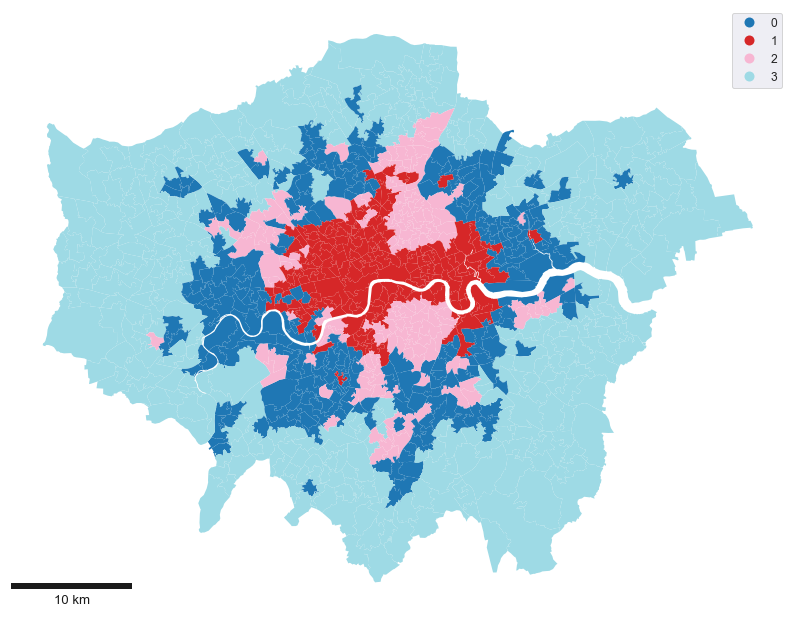

In [23]:
# plot the map of k-means clustering results
fig, ax = plt.subplots(1, figsize=(14, 12))
ax.axis('off')
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, cmap='tab20',legend=True)
ax.add_artist(ScaleBar(1,location = 'lower left'))

msoa_gdf = msoa_gdf.reset_index().set_index('MSOA11CD')
msoa_gdf['kmeans_results'] = rs.KMeans

plt.savefig(odir+'//cluster.png', bbox_inches = 'tight')

In [24]:
# subset the variables and calculate the averages by clusters
attributes = ['bus_stops_den', 'rail_stops_den',  
                           'one_car_or_more_per_2011', 
                           'car_ave_t', 'bus_ave_t', 'rail_ave_t','total_ave_t', 
                           'car_per', 'bus_per', 'rail_per'] 

msoa_gdf_g= msoa_gdf.groupby('kmeans_results')[attributes].agg('mean')
msoa_df_g = pd.DataFrame(msoa_gdf_g)

# rename the variables
msoa_df_g_1 = msoa_df_g.rename(columns={'bus_stops_den': 'Bus stops density (/hectare)', 
                          'rail_stops_den': 'Rail stops density (/hectare)', 
                          'one_car_or_more_per_2011': 'Percentage of households with cars', 
                          'car_ave_t': 'Average commuting time for car (min)', 
                          'bus_ave_t': 'Average commuting time for bus (min)', 
                          'rail_ave_t': 'Average commuting time for rail (min)', 
                          'total_ave_t': 'Total average commuting time (min)', 
                          'car_per': 'Percentage of commuting by car', 
                          'bus_per': 'Percentage of commuting by bus', 
                          'rail_per': 'Percentage of commuting by rail', 
                       })

In [25]:
#set the palette correspond to the clustering results
palette=[plt.cm.tab20(0),plt.cm.tab20(0.33),plt.cm.tab20(0.66),plt.cm.tab20(0.99)]

In [26]:
sns.set(style="darkgrid",font_scale = 1.1)

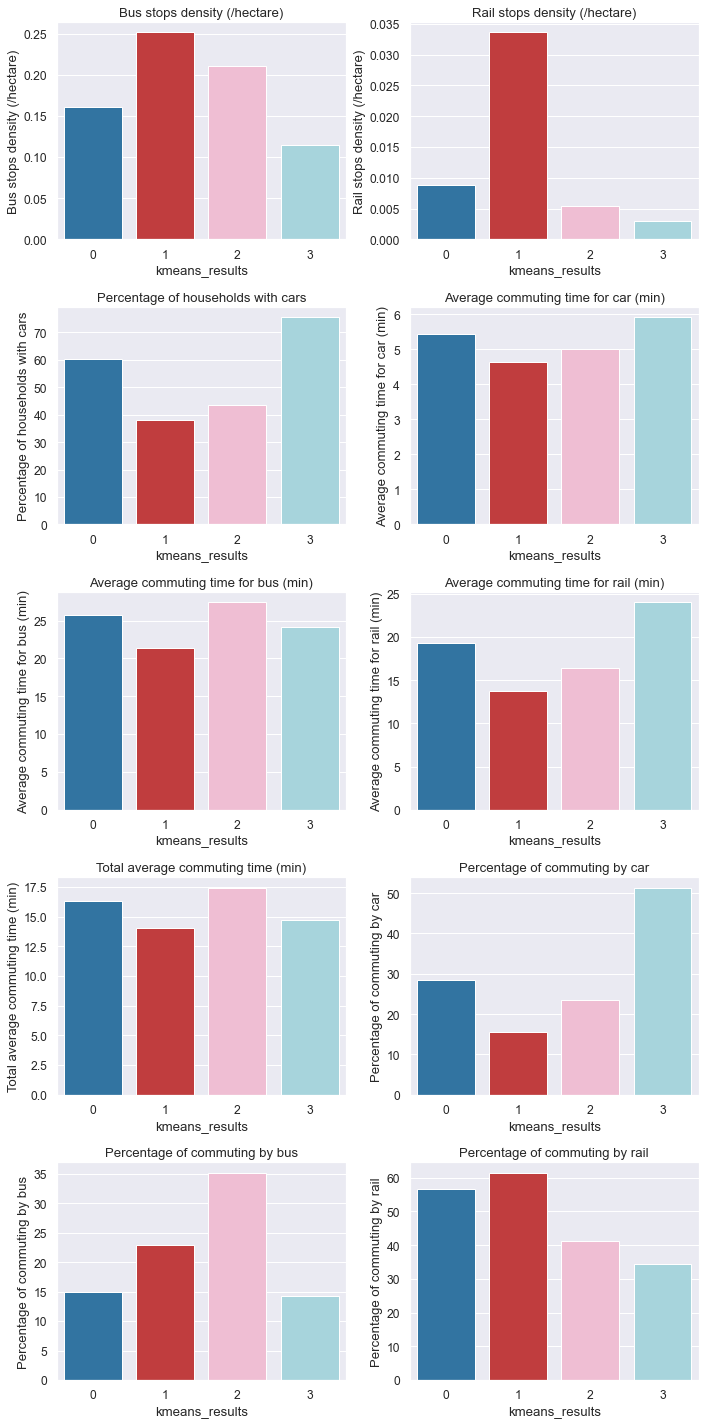

In [27]:
# plot the averages of variables by clusters
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
msoa_results=msoa_df_g_1.reset_index()
sns.barplot(ax=axs[0, 0], data=msoa_results, x="kmeans_results", y="Bus stops density (/hectare)",palette=palette)
axs[0,0].set_title("Bus stops density (/hectare)")
sns.barplot(ax=axs[0, 1], data=msoa_results, x="kmeans_results", y="Rail stops density (/hectare)",palette=palette)
axs[0,1].set_title("Rail stops density (/hectare)")
sns.barplot(ax=axs[1, 0], data=msoa_results, x="kmeans_results", y="Percentage of households with cars",palette=palette)
axs[1,0].set_title("Percentage of households with cars")
sns.barplot(ax=axs[1, 1], data=msoa_results, x="kmeans_results", y="Average commuting time for car (min)",palette=palette)
axs[1,1].set_title("Average commuting time for car (min)")
sns.barplot(ax=axs[2, 0], data=msoa_results, x="kmeans_results", y="Average commuting time for bus (min)",palette=palette)
axs[2,0].set_title("Average commuting time for bus (min)")
sns.barplot(ax=axs[2, 1], data=msoa_results, x="kmeans_results", y="Average commuting time for rail (min)",palette=palette)
axs[2,1].set_title("Average commuting time for rail (min)")
sns.barplot(ax=axs[3, 0], data=msoa_results, x="kmeans_results", y="Total average commuting time (min)",palette=palette)
axs[3,0].set_title("Total average commuting time (min)")
sns.barplot(ax=axs[3, 1], data=msoa_results, x="kmeans_results", y="Percentage of commuting by car",palette=palette)
axs[3,1].set_title("Percentage of commuting by car")
sns.barplot(ax=axs[4, 0], data=msoa_results, x="kmeans_results", y="Percentage of commuting by bus",palette=palette)
axs[4,0].set_title("Percentage of commuting by bus")
sns.barplot(ax=axs[4, 1], data=msoa_results, x="kmeans_results", y="Percentage of commuting by rail",palette=palette)
axs[4,1].set_title("Percentage of commuting by rail")

plt.tight_layout()
plt.savefig(odir+'//cluster_results_1.png', bbox_inches = 'tight') 
plt.show()